# Data loading: MXNet recordIO

## Overview

In this example we will show how to use the data stored in the MXNet recordIO format with DALI.

## Creating index

In order to use data stored in the recordIO format, we need to use `MXNetReader` operator. Besides arguments common to all readers (like `random_shuffle`), it takes `path` and `index_path` arguments.

* `path` is a list of paths to recordIO files
* `index_path` is a list (of size 1) containing path to index file. Index file (with `.idx` extension) is automatically created when using MXNet's `im2rec.py` utility, and can also be obtained from recordIO file using `rec2idx` utility included with DALI.

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
import os.path

test_data_root = os.environ['DALI_EXTRA_PATH']
base = os.path.join(test_data_root, 'db', 'recordio')

idx_files = [base + "/train.idx"]
rec_files = [base + "/train.rec"]
idx_files

['/home/jlisiecki/Dali/DALI_extra/db/recordio/train.idx']

## Defining and running the pipeline

Let us define a simple pipeline that takes images stored in recordIO format, decodes them and prepares them for ingestion in DL framework (crop, normalize and NHWC -> NCHW conversion).

In [2]:
class RecordIOPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(RecordIOPipeline, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = ops.MXNetReader(path = rec_files, index_path = idx_files)

        self.decode = ops.ImageDecoder(device = "mixed", output_type = types.RGB)
        self.cmn = ops.CropMirrorNormalize(device = "gpu",
                                            output_dtype = types.FLOAT,
                                            crop = (224, 224),
                                            image_type = types.RGB,
                                            mean = [0., 0., 0.],
                                            std = [1., 1., 1.])
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.iter = 0

    def define_graph(self):
        inputs, labels = self.input(name="Reader")
        images = self.decode(inputs)
        output = self.cmn(images, crop_pos_x = self.uniform(),
                          crop_pos_y = self.uniform())
        return (output, labels)

    def iter_setup(self):
        pass

Let us now build and run our `RecordIOPipeline`.

In [3]:
batch_size = 16

pipe = RecordIOPipeline(batch_size=batch_size, num_threads=2, device_id = 0)
pipe.build()

In [4]:
pipe_out = pipe.run()

In order to visualize the results we use `matplotlib` library. This library expects images in `HWC` format, whereas the output of our pipeline is in `CHW` (since that is the preferred format for most Deep Learning frameworks). Because of that, for the visualization purposes, we need to transpose the images back to `HWC` layout.

In [5]:
from __future__ import division
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        img_chw = image_batch.at(j)
        img_hwc = np.transpose(img_chw, (1,2,0))/255.0
        plt.imshow(img_hwc)

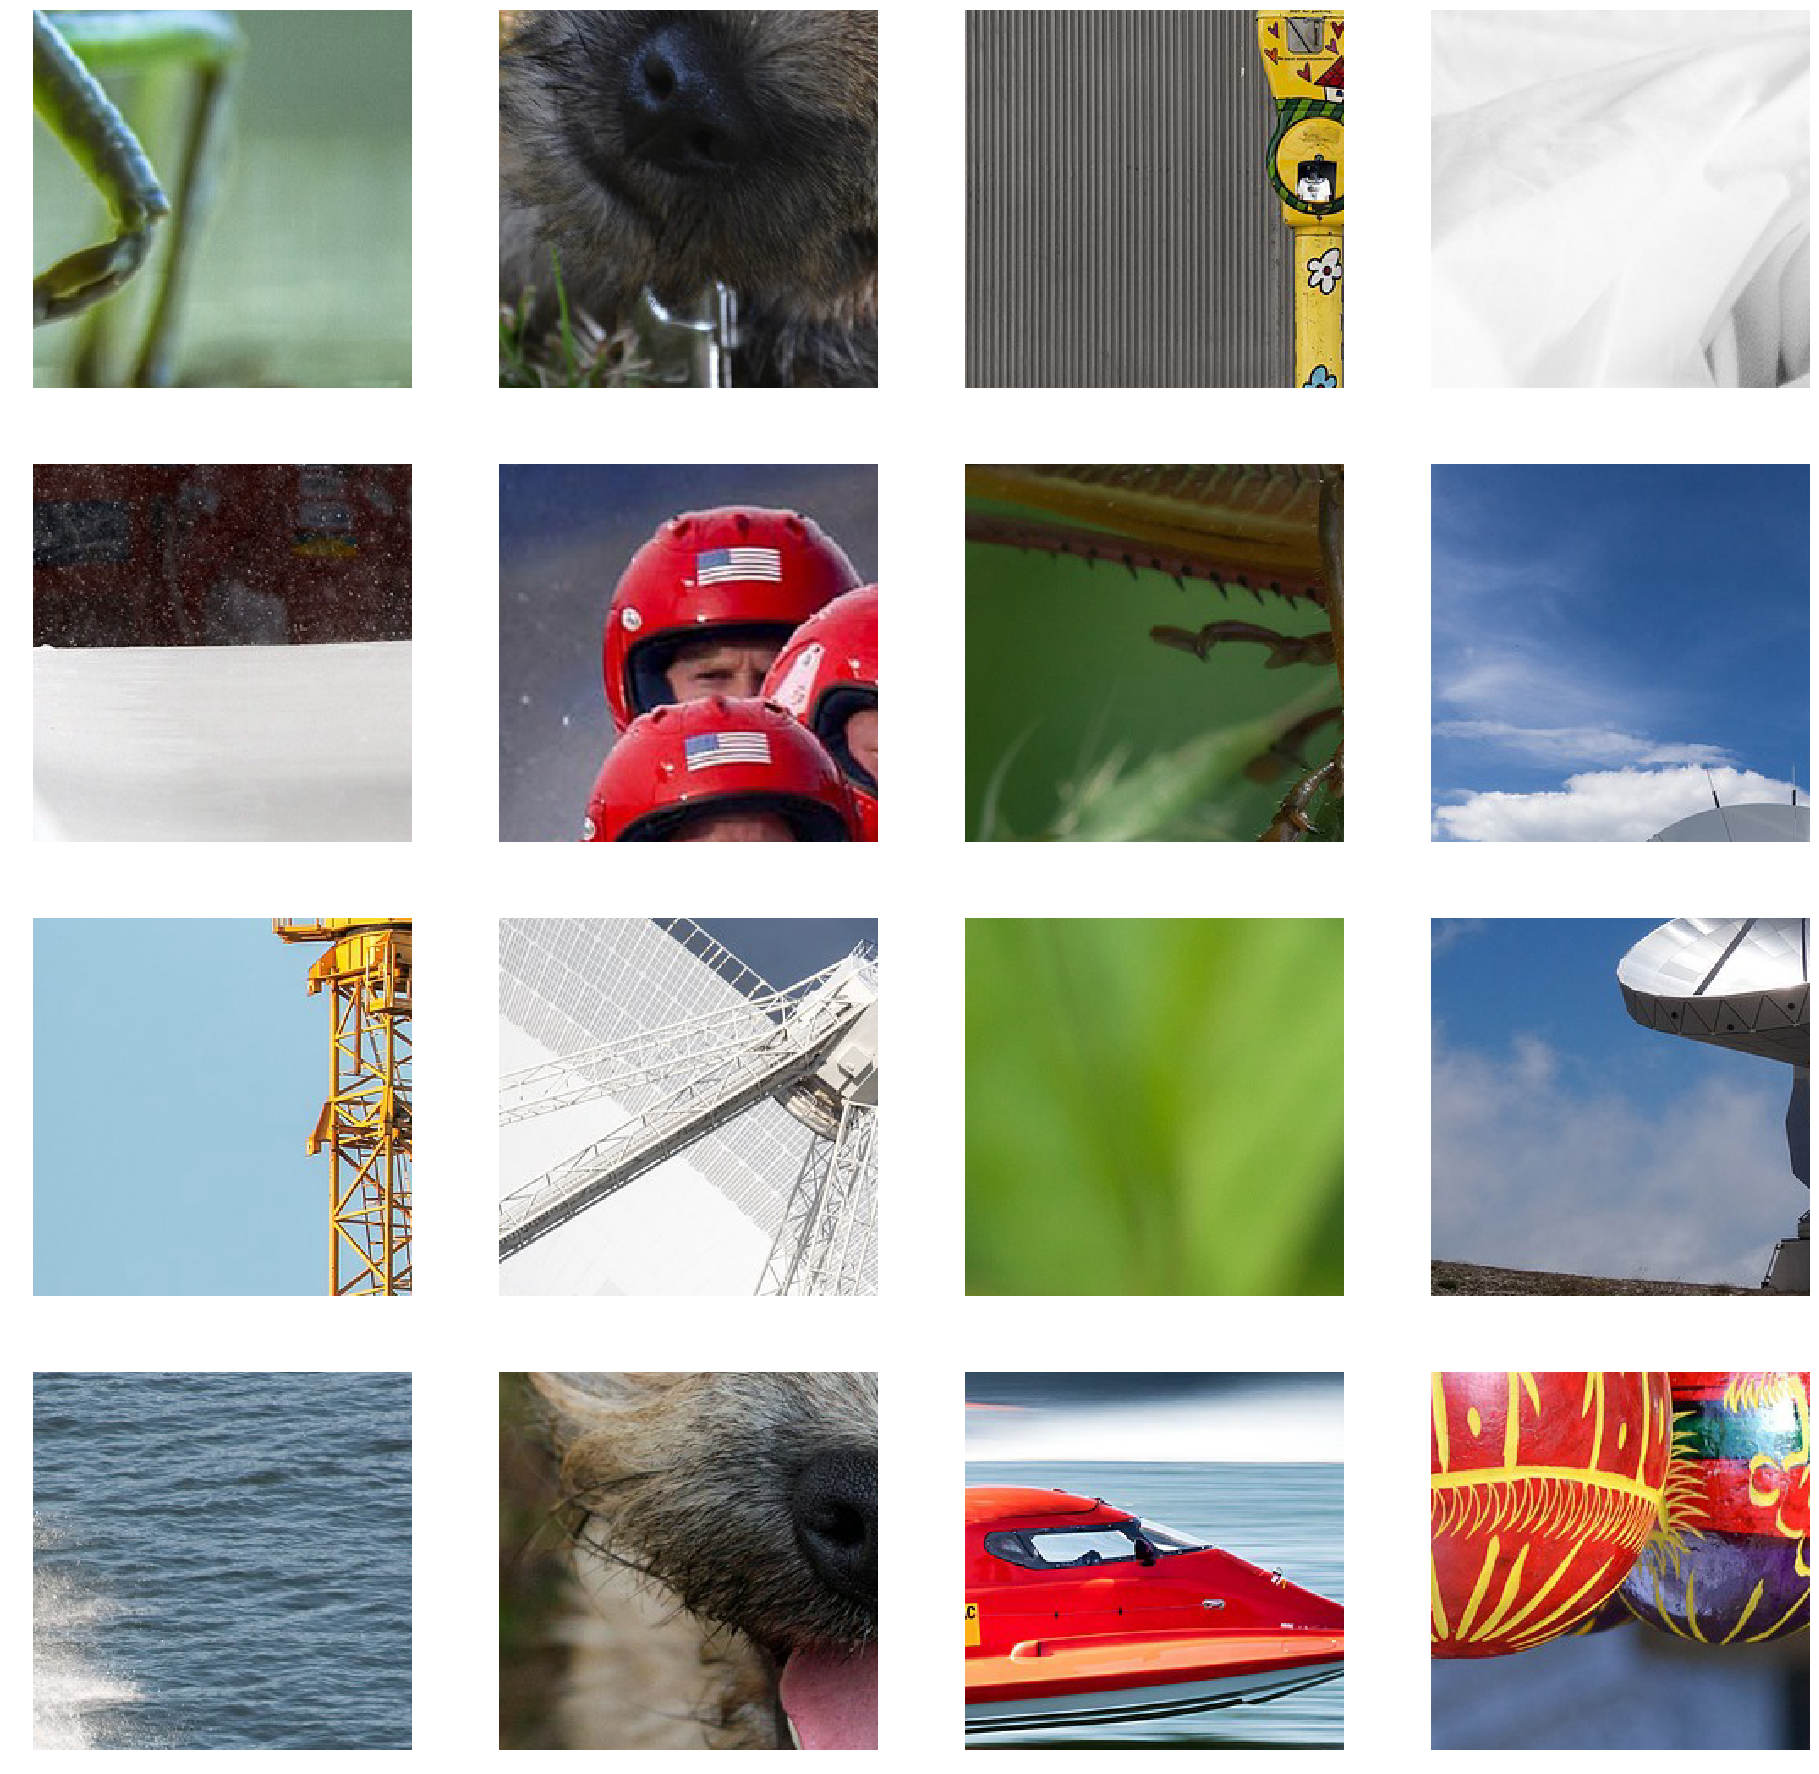

In [6]:
images, labels = pipe_out

show_images(images.as_cpu())